In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from countrygroups import EUROPEAN_UNION
from core import DataLoader

In [3]:
Ethereum = DataLoader('../data/ethereum')

In [4]:
Crypto = DataLoader('../data/crypto')

In [167]:
Christianity = DataLoader('../data/christianity')

In [6]:
Judaism = DataLoader('../data/judaism')

In [ ]:
tag_count_eu = {}
tag_count_usa = {}
usa_names = ['USA', 'United States', 'US']
upvotes = Christianity._votes_df.loc[Christianity._votes_df['VoteTypeId'] == 2, ['Id', 'PostId']].groupby('PostId').count()
posts_with_upvote_count = pd.merge(Christianity._posts_df, upvotes, left_on='Id', right_on='PostId')
answers_with_upvote_count = posts_with_upvote_count.loc[posts_with_upvote_count['PostTypeId'] == 2, ['ParentId', 'Id_y']]\
  .groupby('ParentId').sum()
answers_with_upvote_count.head()
posts_with_tags = Christianity._posts_df.loc[Christianity._posts_df['PostTypeId'] == 1, ['Id', 'OwnerUserId', 'Tags']]\
  .dropna(subset=['OwnerUserId'], inplace=False)
posts_with_tags = pd.merge(posts_with_tags, upvotes, left_on='Id', right_on='PostId')
posts_with_tags_and_upvotes = pd.merge(posts_with_tags, answers_with_upvote_count, left_on='Id_x', right_on='ParentId')
posts_with_tags_and_upvotes['UpVotes'] = posts_with_tags_and_upvotes['Id_y_x'] + posts_with_tags_and_upvotes['Id_y_y']
posts_with_tags_and_upvotes = posts_with_tags_and_upvotes[['Id_x', 'OwnerUserId', 'UpVotes', 'Tags']]\
  .convert_dtypes()
posts_with_tags_and_upvotes = pd.merge(posts_with_tags_and_upvotes, Christianity._users_df, left_on='OwnerUserId', right_on='Id')[['Location', 'UpVotes_x', 'Tags']]\
  .dropna(subset=['Location'], inplace=False)
for index, post in posts_with_tags_and_upvotes.iterrows():
  if any(map(post['Location'].__contains__, usa_names)):
    for tag in post['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_usa[tag] = tag_count_usa.get(tag, 0) + post['UpVotes_x']
    continue
  if any(map(post['Location'].__contains__, EUROPEAN_UNION.names)):
    for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
      tag_count_eu[tag] = tag_count_eu.get(tag, 0) + post['UpVotes_x']
tag_count_by_location = pd.DataFrame({'TagName': tag_count_eu.keys(), 'CountInEU': tag_count_eu.values()})
tag_count_by_location = pd.merge(tag_count_by_location, pd.DataFrame({'TagName': tag_count_usa.keys(), 'CountInUSA': tag_count_usa.values()}), how='outer')\
  .fillna(0)\
  .convert_dtypes()

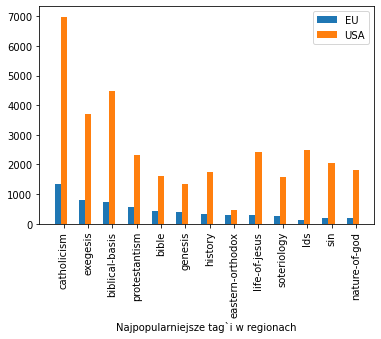

In [303]:
bar_width = 0.25
tag_count = 10
top_tag_count_in_eu = tag_count_by_location.sort_values(by='CountInEU', ascending=False).head(tag_count)
top_tag_count_in_usa = tag_count_by_location.sort_values(by='CountInUSA', ascending=False).head(tag_count)
top_tag_count_by_location = pd.merge(top_tag_count_in_eu, top_tag_count_in_usa, how='outer').fillna(0)
top_tag_count_in_usa
r1 = np.arange(len(top_tag_count_by_location))
r2 = [x + bar_width for x in r1]
plt.bar(r1, top_tag_count_by_location['CountInEU'], width=bar_width, label='EU')
plt.bar(r2, top_tag_count_by_location['CountInUSA'], width=bar_width, label='USA')
plt.xlabel('Najpopularniejsze tag`i w regionach')
plt.xticks([r + bar_width for r in range(len(top_tag_count_by_location))], top_tag_count_by_location['TagName'], rotation='vertical')
plt.legend()
plt.show()